# 04 Multiple Linear regression model 

> k-fold cross validation of regression model choice   

In [1]:
#|default_exp core.04_regression_model

In [2]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02b_LAD_and_GP_intersections.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/02c_GP_doctors_per_LAD.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [3]:
#|hide
from nbdev.showdoc import show_doc

In [4]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [5]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [6]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [7]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [8]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc', 
             'GP_LAD_pc']

This performs 5 fold cross-validation to determine the best combination of covariates. 

In [9]:
#|export 

# Outcome data 
Y_data = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# Parameters for cross validation 
n_folds = 5
cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# Model 
model = linear_model.LinearRegression()

covar_comb = {}
perform_by_covar = {}

key_num = 0
for i in range(1,9):
    for j, subset in enumerate(itertools.combinations(covar_opt, i)):
        covar_comb[key_num] = subset
        X_data = df_dem_plus[list(subset)].values.reshape(-1,i)
        # evaluate the model using 5-fold CV 
        scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
        perform_by_covar[key_num] = np.mean(scores)
        key_num += 1
        #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [10]:
# Best combination of covariates
covar_comb[max(perform_by_covar, key=perform_by_covar.get)]

('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc')

In [11]:
# Top 5 combination of covariates 
max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
[f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

["Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7711839280264933",
 "Covariates:('over_65_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7711196881520097",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc'), Accuracy:0.7708235715056528",
 "Covariates:('over_65_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc'), Accuracy:0.7704441074351089",
 "Covariates:('over_65_pc', 'STIA_afflicted_pc'), Accuracy:0.7702740457309754"]

In [12]:
# Create dataframe of combinations of covariates
df_covar_comb = pd.DataFrame.from_dict(covar_comb, orient='index')
df_covar_comb.columns = ['covariate 1', 'covariate 2', 'covariate 3', 'covariate 4', 'covariate 5', 'covariate 6', 'covariate 7', 'covariate 8']

# Create dataframe of accuracy
df_accuracy = pd.DataFrame.from_dict(perform_by_covar, orient='index')
df_accuracy.rename(columns={0:'accuracy (mean)'}, inplace=True)

# Merge 
df_model_acc = pd.merge(df_accuracy, df_covar_comb, left_index=True, right_index=True)

In [13]:
# This dataframe records the model accuracy for every combination of covariates 
df_model_acc

,accuracy (mean),covariate 1,covariate 2,covariate 3,covariate 4,covariate 5,covariate 6,covariate 7,covariate 8
0,0.743587,over_65_pc,None,None,None,None,None,None,None
1,-0.055047,female_pc,None,None,None,None,None,None,None
2,0.116131,ALevel_plus_pc,None,None,None,None,None,None,None
3,0.549307,white_pc,None,None,None,None,None,None,None
4,0.637414,HYP_afflicted_pc,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
250,0.767015,over_65_pc,female_pc,ALevel_plus_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
251,0.768299,over_65_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
252,0.767544,over_65_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None
253,0.745420,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc,None


How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [14]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [15]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-60]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Chiltern',
 'Wycombe',
 'Aylesbury Vale',
 'South Northamptonshire',
 'South Bucks']

2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

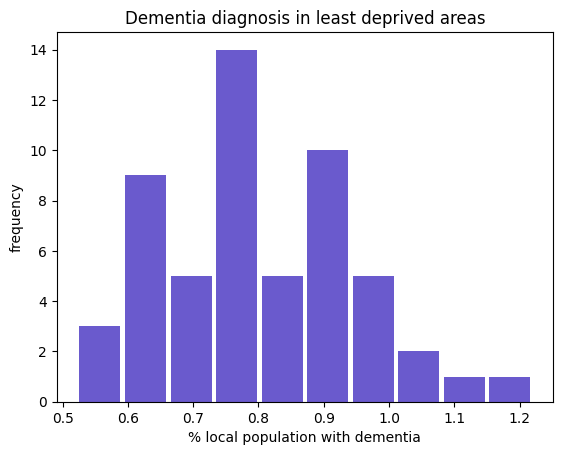

In [16]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

In [17]:
# # Potential covariates 
# covar_opt = ['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']

# # Outcome data 
# Y_data = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

# # Parameters for cross validation 
# n_folds = 2
# cv_kfold = KFold(n_folds, random_state=13, shuffle=True)

# # Model 
# model = linear_model.LinearRegression()

# covar_comb = {}
# perform_by_covar = {}

# key_num = 0
# for i in range(1,8):
#     for j, subset in enumerate(itertools.combinations(covar_opt, i)):
#         covar_comb[key_num] = subset
#         X_data = df_dem_topIMD[list(subset)].values.reshape(-1,i)
#         model.fit(X=X_data, y=Y_data)
#         scores = model.score(X=X_data, y=Y_data)
#         # evaluate the model using 5-fold CV 
#         #scores = cross_val_score(model, X=X_data, y=Y_data, cv=cv_kfold)
#         perform_by_covar[key_num] = np.mean(scores)
#         key_num += 1
#         #print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [18]:
# # Top 5 combination of covariates 
# max_5 = sorted(perform_by_covar, key=perform_by_covar.get, reverse=True)[:5]
# [f'Covariates:{covar_comb[x]}, Accuracy:{perform_by_covar[x]}' for x in max_5]

In [19]:
# # Multiple linear regression including all the covariates 

# x_covar = df_dem_topIMD[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)
# y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

# x_test_all_covar = df_dem_plus[['over_65_pc', 'female_pc', 'ALevel_plus_pc']].values.reshape(-1,3)

# regr = linear_model.LinearRegression()

# # fit regression comorbidities
# regr.fit(x_covar, y)
# y_pred_all = regr.predict(x_test_all_covar)

# # comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
# true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

# # residuals 
# all_var_residuals = true_val-y_pred_all

In [20]:
# # 5th and 95th perctile of the residuals 
# ci_5, ci_95 = np.abs(st.norm.interval(confidence=0.95, 
#                  loc=np.mean(all_var_residuals), 
#                  scale=np.std(all_var_residuals)))

# x_vals = np.arange(0, 1.5, 0.01)

# plt.plot(x_vals, x_vals, ':', color='yellowgreen') # y=x line 
# plt.plot(x_vals, x_vals-ci_5, ':', color='goldenrod')
# plt.plot(x_vals, x_vals+ci_95, ':', color='goldenrod')
# plt.scatter(true_val, y_pred_all, color='plum')
# plt.xlabel('% population with dementia')
# plt.ylabel('predicted % population with dementia')
# plt.title('Multiple linear regression model')
# plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
# plt.text(1.1, 0.75, r'5th percentile', fontsize=10, color='goldenrod')
# plt.text(0.7, 1.25, r'95th percentile', fontsize=10, color='goldenrod')
# plt.text(0.2, 1.1, r'potential underdiagnosis', fontsize=10)
# plt.show()

In [21]:
# # look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
# resid_gap_area = df_dem_plus[-all_var_residuals>ci_95]['area_name']
# #[x for x in list(resid_gap_area)]
# df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

## All possible covariates 
What happens if I include all possible covariates?

In [22]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [23]:
# Linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

In [24]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.31293386567688863
-------- 
 coefficients of independent variables 
 
over_65_pc:0.018826502157264044 

female_pc:0.007082685397652472 

ALevel_plus_pc:-0.0065006226140778625 

white_pc:-0.00494408783267441 

HYP_afflicted_pc:0.005088706983298675 

DM_afflicted_pc:-0.020680697151659856 

STIA_afflicted_pc:0.22470244482263949 

GP_LAD_pc:-0.15968462545378456 



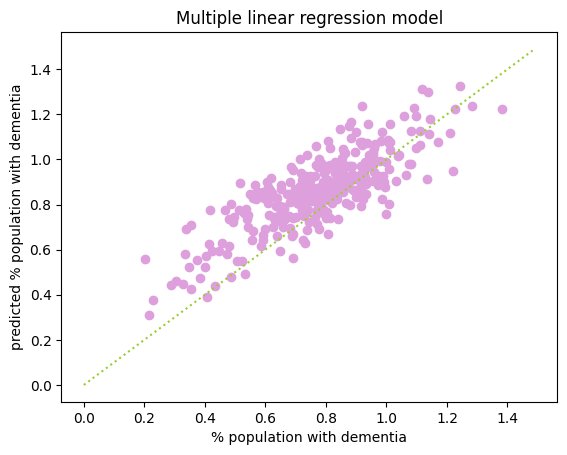

In [25]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
#plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

In [26]:
# residuals 
all_var_residuals = y_pred_all.squeeze()-true_val.squeeze()

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[all_var_residuals>0.3]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

21     Barking and Dagenham
73                   Slough
75                 Redditch
90               Birmingham
132                  Ealing
197                Sandwell
284                  Newham
286                Torridge
290                   Brent
Name: area_name, dtype: object


In [27]:
all_var_residuals = all_var_residuals.reshape(309)
worst_5_resid = np.argsort(all_var_residuals)[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name', 'DEM_afflicted_pc', 'over_65_pc', 'ALevel_plus_pc', 'female_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']]

,area_name,DEM_afflicted_pc,over_65_pc,ALevel_plus_pc,female_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
276,Fenland,0.714117,28.112499,35.765901,62.474242,85.9,16.615140,7.127223,2.042050,0.144190
107,Cornwall,0.845086,30.474466,49.533117,61.882286,93.6,16.116527,5.929376,2.893800,0.090167
271,Eden,0.767866,31.807602,50.422430,60.834222,94.8,17.315794,6.186893,2.594808,0.185516
39,Blackburn with Darwen,0.606598,19.512210,44.044775,67.703411,56.9,14.049137,6.951609,1.780689,0.132134
163,Luton,0.548098,16.430969,47.499642,69.677893,31.8,12.431323,7.227025,1.336864,0.110126
294,Nuneaton and Bedworth,0.617058,24.596579,43.022478,65.301216,81.8,16.726585,7.125689,1.970514,0.121875
290,Brent,0.466172,15.479322,56.087884,66.915271,15.2,11.711521,7.442579,1.100870,0.113296
90,Birmingham,0.487842,17.074968,47.300055,65.987028,42.9,11.834857,6.972400,1.403053,0.072518
286,Torridge,0.920801,33.747315,43.633971,60.595739,96.1,17.156142,6.717727,3.111689,0.191135
75,Redditch,0.565329,23.755111,44.297777,64.493804,82.4,14.490801,6.365785,1.954713,0.095776


In [28]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
36,E06000039,Slough,19788.26,73,22.965,103,0.0000,195,0.1122,152,27534.97,172
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
237,E07000236,Redditch,17343.30,118,22.524,107,0.0909,86,0.2596,80,30212.17,104
271,E08000025,Birmingham,25319.55,6,38.067,7,0.4131,7,0.5792,4,32208.16,30
274,E08000028,Sandwell,25276.49,8,34.884,12,0.1989,44,0.5349,10,31705.52,53
285,E09000002,Barking and Dagenham,25551.85,5,32.768,21,0.0364,139,0.4724,20,29391.87,125
288,E09000005,Brent,21083.02,49,25.558,79,0.0578,116,0.2074,101,29908.65,114
292,E09000009,Ealing,18991.69,88,22.710,105,0.0204,163,0.1630,127,28827.66,143
308,E09000025,Newham,24138.70,12,29.577,43,0.0244,154,0.2884,67,28987.07,137


In [29]:
df_dem_plus['residual'] = all_var_residuals

In [30]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [31]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [32]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,residual,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,215.158147,0.142036,-0.004348,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995,-0.055570,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,123.466346,0.129934,-0.098166,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,612.399689,0.497021,-0.238217,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,77.360723,0.113788,0.162971,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,56.529709,23.255361,67.640458,13.291837,5.650779,1.602052,222.131324,0.267883,0.010010,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,41.179556,24.755926,61.709289,17.399056,6.822075,2.356606,398.125138,0.174020,0.144676,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,55.991742,27.061403,64.901694,15.234047,5.791747,2.049750,293.938550,0.104266,0.118623,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,58.748701,28.978935,62.294084,14.819090,4.788832,2.072753,117.926289,0.163412,-0.071142,294


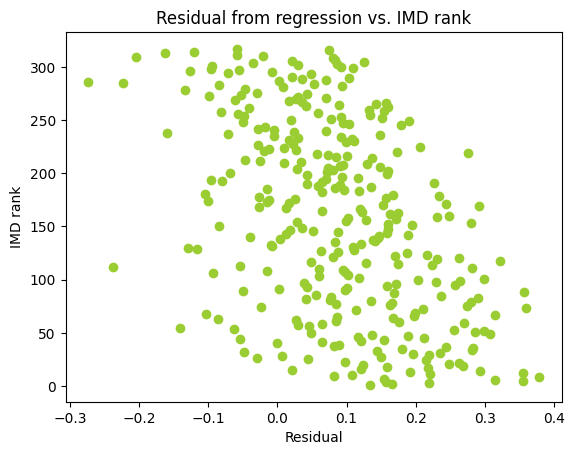

In [33]:
plt.scatter(df_dem_plus_IMD['residual'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [34]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

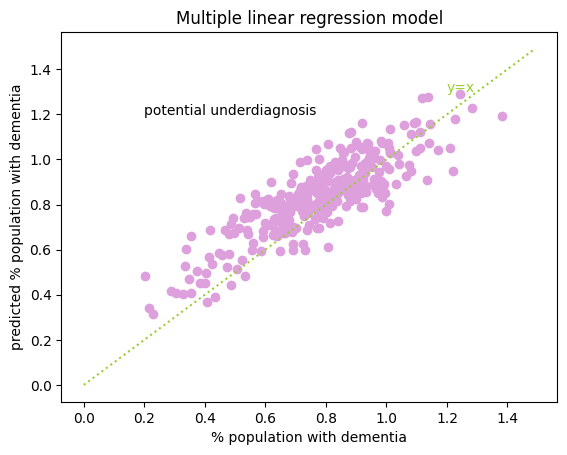

In [35]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [36]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.19011864576319404
-------- 
 coefficients of independent variables 
 
over_65_pc:0.021739464197558196 

female_pc:0.004275571054316298 

ALevel_plus_pc:-0.004718078458165609 

white_pc:-0.003163015965931863 

HYP_afflicted_pc:0.01455257622991945 

DM_afflicted_pc:-0.013227272662883894 

STIA_afflicted_pc:0.10717538794687316 

GP_LAD_pc:-0.03761093249805121 



In [37]:
np.dot(np.array(x_test_all_covar), regr.coef_[0]) + regr.intercept_[0]

array([1.17886359, 0.59595594, 0.78964987, 0.76986408, 0.95762173,
       0.70911729, 0.81637759, 0.85136213, 0.91296714, 0.79118214,
       0.84957569, 0.86125686, 0.89538644, 1.07134832, 0.92390905,
       0.89807301, 1.03349221, 0.7955494 , 0.85074106, 0.88622453,
       0.66897922, 0.60459572, 0.79377745, 0.88324622, 1.03834752,
       0.94881519, 0.80810021, 0.98591356, 0.91534381, 1.19391026,
       0.8591363 , 1.15602532, 0.4416283 , 0.97581682, 0.7967697 ,
       1.13555779, 0.86429784, 0.73977679, 1.04740972, 0.81436875,
       1.06791392, 0.40448764, 0.5530166 , 0.65847168, 0.86103087,
       0.81003879, 0.73667165, 0.94150893, 0.49809005, 0.89589585,
       0.94010101, 0.58067943, 0.71705155, 0.74563542, 0.78570512,
       0.90745938, 1.1655669 , 0.69650188, 0.67415885, 0.99862998,
       0.74218644, 1.03729008, 0.31653912, 1.05160456, 0.8442607 ,
       0.65501077, 0.9536198 , 0.7935345 , 0.82385753, 0.6864783 ,
       0.6834494 , 1.03368386, 0.88454222, 0.68505331, 1.15473

### Lasso regression 

In [38]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

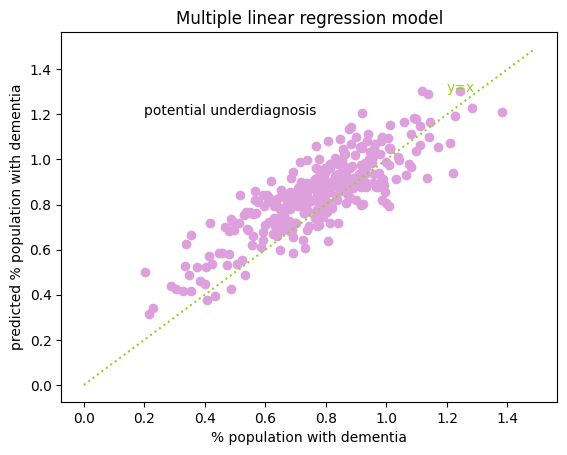

In [39]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [40]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.09231771619329654
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01883902789186213 

female_pc:0.005324509840840281 

ALevel_plus_pc:-0.004366294959799784 

white_pc:-0.0030462972119286043 

HYP_afflicted_pc:0.0074516115914967295 

DM_afflicted_pc:-0.0031765348826858575 

STIA_afflicted_pc:0.17126583697847442 

GP_LAD_pc:-0.0 

